Multiclass classification with GPflow
--

*Alexander G. de G. Matthews and James Hensman, 2016*
*Minor edits John Bradshaw 2018*

In [1]:
import gpflow
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from gpflow.test_util import nb_niter
plt.style.use('ggplot')
%matplotlib inline

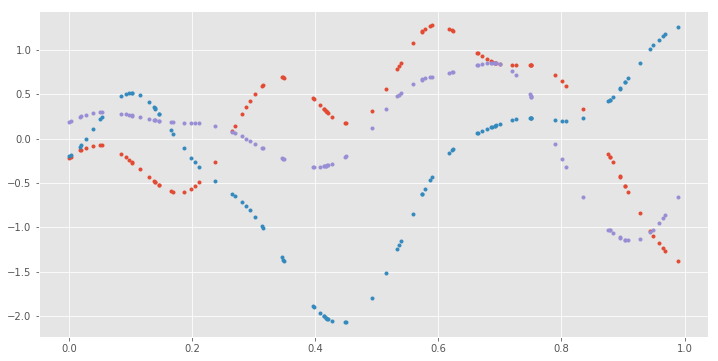

In [2]:
#make a one dimensional classification problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))

plt.figure(figsize=(12,6))
plt.plot(X, f, '.');

In [3]:
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)

### Sparse Variational Gaussian approximation

In [4]:
m = gpflow.models.SVGP(
    X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
    likelihood=gpflow.likelihoods.MultiClass(3),
    Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)

m.kern.kernels[1].variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.417022004702574], [0.0923385947687978], [0..."
SVGP/likelihood/invlink/epsilon,Parameter,"Beta([0.2],[5.])","[0.0, 1.0]",False,(),True,0.001
SVGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ..."


In [5]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=nb_niter(1000))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.379984
  Number of iterations: 164
  Number of functions evaluations: 194


In [6]:
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

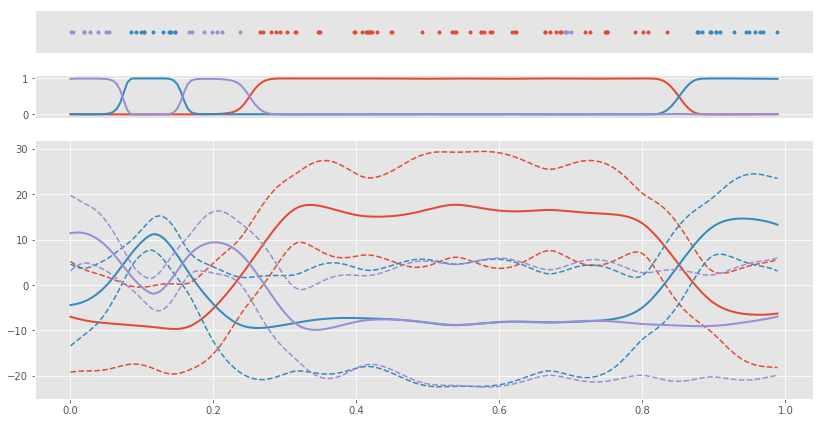

In [7]:
plot(m)

In [8]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[1.6801518935490563, -0.8211002650598448, -0...."
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.417022004702574], [0.0923385947687978], [0..."
SVGP/likelihood/invlink/epsilon,Parameter,"Beta([0.2],[5.])","[0.0, 1.0]",False,(),True,0.001
SVGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,80.59979748331513
SVGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.10403582798881622
SVGP/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[0.4722841391617176, 0.5894950864859919, 0.54..."


#### Learning the epsilon parameter of the RobustMax
Note that the epsilon parameter of the robustmax likelihood is fixed as default.
We can instead learn this parameter if we so wished. This may be useful if you have overlapping classes or outliers. We try this on the same model below. Note that by default we have put a Beta prior on the epsilon parameter, encourgaing its value to be small.

In [9]:
m2 = gpflow.models.SVGP(
    X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
    likelihood=gpflow.likelihoods.MultiClass(3),
    Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)

m2.kern.kernels[1].variance.trainable = False
m2.feature.trainable = False
m2.likelihood.invlink.epsilon.set_trainable(True)
m2.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.417022004702574], [0.0923385947687978], [0..."
SVGP/likelihood/invlink/epsilon,Parameter,"Beta([0.2],[5.])","[0.0, 1.0]",True,(),True,0.001
SVGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ..."


In [10]:
opt.minimize(m2, maxiter=nb_niter(1000))
m2.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 58.929387
  Number of iterations: 103
  Number of functions evaluations: 116


,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[1.6218847381033739, -0.8162747434684163, -0...."
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.417022004702574], [0.0923385947687978], [0..."
SVGP/likelihood/invlink/epsilon,Parameter,"Beta([0.2],[5.])","[0.0, 1.0]",True,(),True,0.07090029057205956
SVGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,80.6143985481072
SVGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.1076993406499665
SVGP/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[0.508731944004579, 0.6304760915684482, 0.594..."


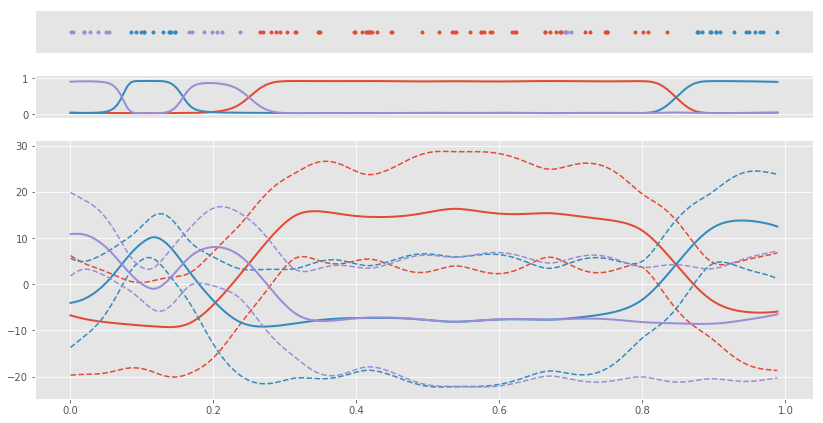

In [11]:
plot(m2)

In [12]:
print("The log likelihood of the the first model, where we do not learn epsilon, is {} and the second is {}.".format(
    m.compute_log_likelihood(), m2.compute_log_likelihood()))

The log likelihood of the the first model, where we do not learn epsilon, is -75.77495271926213 and the second is -56.81391750036175.


### Sparse MCMC

In [13]:
tf.reset_default_graph()
gpflow.reset_default_session()

In [14]:
with gpflow.defer_build():
    m = gpflow.models.SGPMC(X, Y, 
                     kern=gpflow.kernels.Matern32(1, lengthscales=0.1) + gpflow.kernels.White(1, variance=0.01),
                     likelihood=gpflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3)
    m.kern.kernels[0].variance.prior = gpflow.priors.Gamma(1., 1.)
    m.kern.kernels[0].lengthscales.prior = gpflow.priors.Gamma(2., 2.)
    m.kern.kernels[1].variance.trainables = False
    
m.compile()

In [15]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=nb_niter(10))

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 153.306077
  Number of iterations: 11
  Number of functions evaluations: 14


In [16]:
hmc = gpflow.train.HMC()
samples = hmc.sample(m, num_samples=nb_niter(500, test_n=20), epsilon=0.04, lmax=15, logprobs=False) # verbose=True

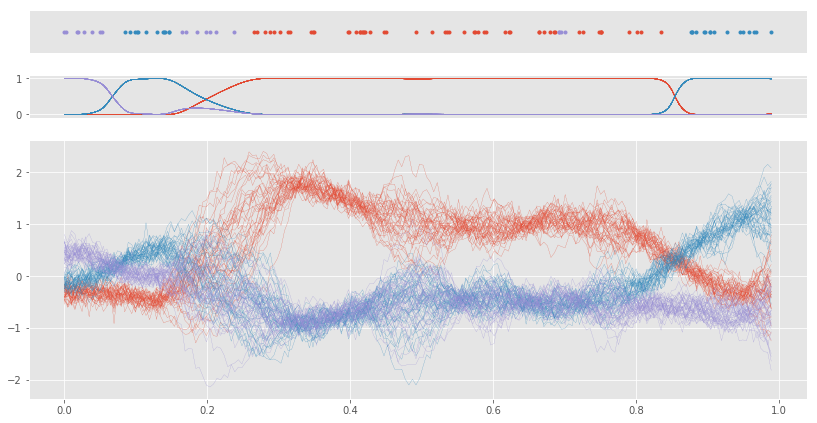

In [17]:
def plot_from_samples(m, samples):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    
    Fpred, Ypred = [], []
    for i, s in samples[nb_niter(100, test_n=0)::10].iterrows(): # burn 100, thin 10
        feed_dict = m.sample_feed_dict(s)
        Ypred.append(m.predict_y(xx, feed_dict=feed_dict)[0])
        Fpred.append(m.predict_f_samples(xx, 1, feed_dict=feed_dict).squeeze())

    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten() == i]
        points, = a3.plot(x, x*0, '.')
        color = points.get_color()
        for F in Fpred:
            a1.plot(xx, F[:,i], color=color, lw=0.2, alpha=1.0)
        for Y in Ypred:
            a2.plot(xx, Y[:,i], color=color, lw=0.5, alpha=1.0)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])
        
    a3.set_xticks([])
    a3.set_yticks([])
    

plot_from_samples(m, samples)

In [18]:
samples.head()

,SGPMC/V,SGPMC/feature/Z,SGPMC/kern/kernels/0/lengthscales,SGPMC/kern/kernels/0/variance,SGPMC/kern/kernels/1/variance
0,"[[1.7751574056612849, -0.9163147104817884, -0....","[[0.32825050204995976], [0.1254539807524326], ...",0.121302,1.016545,0.009559
1,"[[1.7751574056612849, -0.9163147104817884, -0....","[[0.32825050204995976], [0.1254539807524326], ...",0.121302,1.016545,0.009559
2,"[[1.7751574056612849, -0.9163147104817884, -0....","[[0.32825050204995976], [0.1254539807524326], ...",0.121302,1.016545,0.009559
3,"[[1.7751574056612849, -0.9163147104817884, -0....","[[0.32825050204995976], [0.1254539807524326], ...",0.121302,1.016545,0.009559
4,"[[1.7751574056612849, -0.9163147104817884, -0....","[[0.32825050204995976], [0.1254539807524326], ...",0.121302,1.016545,0.009559


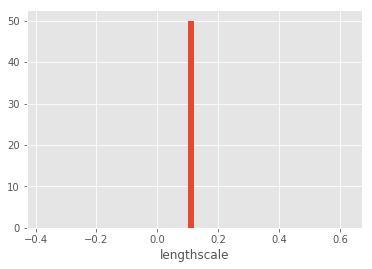

In [19]:
plt.hist(np.vstack(samples['SGPMC/kern/kernels/0/lengthscales']).flatten(), 50, density=True)
plt.xlabel('lengthscale');